# 003 Main Analysis 1
# Analyzing Neighborhood Activity and Exposure Density

* This notebook contains code for one of the main analyses, developing exposure density metric and analyzing neighborhood activity change before and after the stay-at-home order in NYC. 
* This notebook also presents visualizing time series and sptaial patterns of neighborhood activities and exposure density change.
* Figure S2 and S3 in "Exposure Density and Neighborhood Disparities in COVID-19 Infection Risk" published in Proceedings of the National Academy of Sciences of the United States of America (PNAS)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check package/module versions
import types 
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

import pkg_resources
root_packages = [i.split('.', 1)[0] for i in list(imports())] 
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print (m.project_name, m.version)

pandas 1.1.2
numpy 1.19.2
matplotlib 3.2.0
geopandas 0.8.1


# Data preparation
## 1. Load Data 
### 1) 250m $\times$ 250m grid data

In [3]:
# grid cell file
grid = pd.read_csv('../../../../../scratch/share/UIL/VenPath/Data/covid_nyc/nyc_land_use/nyc_250mGrid_landUse_active14days_file_breakdown.csv')
grid.head()

,cell_label,x_index,y_index,lon,lat,land_use_distribution
0,1;43,1,43,-74.251148,40.593881,{0.0: 62370}
1,2;90,2,90,-74.248183,40.699518,{0.0: 62700}
2,3;99,3,99,-74.245218,40.719746,{0.0: 62370}
3,3;39,3,39,-74.245218,40.584890,{0.0: 62370}
4,4;109,4,109,-74.242253,40.742222,{0.0: 62181}


### 2) 250m grid cell level hourly mobility data associated with land use types
__Land use classification__

     calssification = {
            0:"non-NYC",
            1:"land",  # including sidewalks
            10:"residential",
            11:'residentialBldg',
            20:"mixed",
            21:"mixedBldg",
            30:"commercial",
            31:"commercialBldg",
            40:"industrial",
            41:"industrialBldg",
            50:"openSpace",
            51:"openSpaceBldg",
            60:"parking",
            61:"parkingBldg",
            70:"other",
            71:"otherBldg",
            80:"roads_pedestrianAccess",
            90:"highways",
            100:"roads_other",
        }

In [4]:
data = pd.read_csv('../../../../../scratch/share/UIL/VenPath/Data/covid_nyc/nyc_land_use/nyc_250mGrid_landUse_uniqueDev_hourlyCounts_active14days_file.csv')
data.head()

,timestamp,cell_label,class,activity
0,2020-03-24 14:00:00,0;113,0.0,6
1,2020-03-22 19:00:00,3;1,11.0,4
2,2020-04-14 19:00:00,6;175,0.0,3
3,2020-04-13 23:00:00,7;143,0.0,1
4,2020-04-21 00:00:00,8;132,0.0,10


### 3) Data investigation and timezone adjustment

* Fill NaT with '2020-03-08 02:00:00'
* Make a 5-hour time shift (left side), if an original timestamp (UTC) is before start of daylight saving ('2020-03-08 02:00:00')
* Mmake an 1-hour time shift to right side (+1hr), if an EST timestamp is equal to or after '2020-03-08 02:00:00'

In [5]:
data['timestamp'] = data['timestamp'].fillna('2020-03-08 02:00:00')
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['timestamp_est'] = data['timestamp'] - pd.Timedelta(hours=5)
data['timestamp_est'][data['timestamp_est']>='2020-03-08 02:00:00'] = data['timestamp_est'] + pd.Timedelta(hours=1)

## 2. Grouping detailed land use types
* Out of the city boundary (this will be dropped)
* Residential
* Non residential
* Outdoor 
* Highway or vehicle only road

In [6]:
data['label'] = 'NN' # out of the city boundary
data['label'][data['class'].isin([10, 11, 20, 21])] = 'R' # residential
data['label'][data['class'].isin([30, 31, 40, 41, 60, 61, 70, 71])] = 'NR' # non residential
data['label'][data['class'].isin([1, 50, 51, 80, 100])] = 'O' # outdoor
data['label'][data['class'].isin([90])] = 'V' # highway
# print (data['label'].value_counts())
# print (data['label'].isnull().sum())

data.head()

,timestamp,cell_label,class,activity,timestamp_est,label
0,2020-03-24 14:00:00,0;113,0.0,6,2020-03-24 10:00:00,NN
1,2020-03-22 19:00:00,3;1,11.0,4,2020-03-22 15:00:00,R
2,2020-04-14 19:00:00,6;175,0.0,3,2020-04-14 15:00:00,NN
3,2020-04-13 23:00:00,7;143,0.0,1,2020-04-13 19:00:00,NN
4,2020-04-21 00:00:00,8;132,0.0,10,2020-04-20 20:00:00,NN


## 3. Join grid cell coordinates to zipcode information

In [7]:
# convert grid cell info to Geopandas Geodataframe
gdf_grid = gpd.GeoDataFrame(grid, geometry=gpd.points_from_xy(grid.lon, grid.lat))

# zipcode
zipcode = gpd.read_file('../data/shape/nyc_doh_MODZCTA_with_county.shp', dtype={'MODZCTA':str})
zipcode_4326  = zipcode.to_crs({'init': 'epsg:4326'})

# spatial join grid cell coordinates to zipcode
grid_zipcode = gpd.sjoin(gdf_grid, zipcode_4326, how='left', op="within")

## 4. Add zipcode information to activity data

In [8]:
data = pd.merge(data, grid_zipcode[['cell_label','MODZCTA']], how='left', on='cell_label')
data.head()

,timestamp,cell_label,class,activity,timestamp_est,label,MODZCTA
0,2020-03-24 14:00:00,0;113,0.0,6,2020-03-24 10:00:00,NN,NaN
1,2020-03-22 19:00:00,3;1,11.0,4,2020-03-22 15:00:00,R,10307
2,2020-04-14 19:00:00,6;175,0.0,3,2020-04-14 15:00:00,NN,NaN
3,2020-04-13 23:00:00,7;143,0.0,1,2020-04-13 19:00:00,NN,NaN
4,2020-04-21 00:00:00,8;132,0.0,10,2020-04-20 20:00:00,NN,NaN


# Temporal change of activities
## 1. Citywide analysis

### (1) Data conversion: hourly average activities per grid cell by land use type


In [9]:
# citywide average hourly activities per grid cell by land use types
df_c_h_avg = data[['timestamp_est', 'label', 'activity']].groupby(['timestamp_est', 'label']).mean().reset_index()

In [10]:
df_c_h_avg = df_c_h_avg[(df_c_h_avg['timestamp_est']>='2020-02-13 00:00:00')&(df_c_h_avg['timestamp_est']<'2020-04-27 00:00:00')]
df_c_h_avg = df_c_h_avg.pivot(index='timestamp_est', columns='label', values='activity')
df_c_h_avg.head()

label,NN,NR,O,R,V
timestamp_est,,,,,
2020-02-13 00:00:00,3.846851,2.677170,3.021604,3.226362,2.508532
2020-02-13 01:00:00,3.246276,2.280111,2.574031,2.747442,2.125749
2020-02-13 02:00:00,2.992567,2.040420,2.326328,2.521921,1.941685
2020-02-13 03:00:00,2.849003,2.023946,2.207217,2.384487,1.838636
2020-02-13 04:00:00,3.087443,2.166667,2.325295,2.475940,2.060606


In [11]:
timestamp_est = df_c_h_avg.index

### 2)  Time series: Neighborhood activity by land use type by 250m grid cell before and after the stay-at-home order
__Citywide average neighborhood activity volume change__

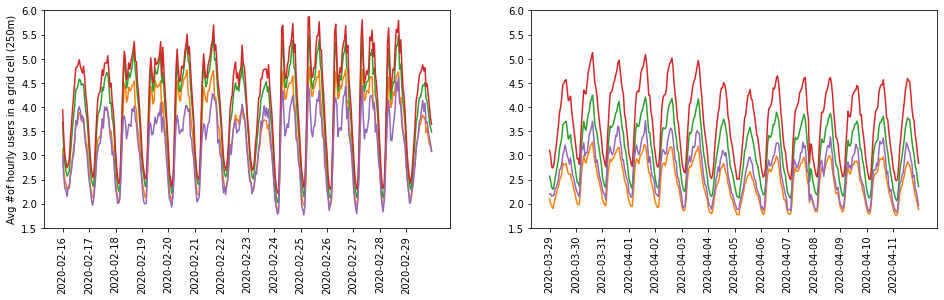

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
xticks = timestamp_est[72:72+336]
plt.plot(df_c_h_avg['NR'].iloc[72:72+336], color='tab:orange')
plt.plot(df_c_h_avg['O'].iloc[72:72+336], color='tab:green')
plt.plot(df_c_h_avg['R'].iloc[72:72+336], color='tab:red')
plt.plot(df_c_h_avg['V'].iloc[72:72+336], color='tab:purple')
plt.ylim(1.5,6)
plt.xticks(xticks[::24], rotation=90)
plt.ylabel('Avg #of hourly users in a grid cell (250m)')

plt.subplot(1,2,2)
xticks = timestamp_est[912+168:912+336+168]
plt.plot(df_c_h_avg['NR'].iloc[912+168:912+336+168], color='tab:orange')
plt.plot(df_c_h_avg['O'].iloc[912+168:912+336+168], color='tab:green')
plt.plot(df_c_h_avg['R'].iloc[912+168:912+336+168], color='tab:red')
plt.plot(df_c_h_avg['V'].iloc[912+168:912+336+168], color='tab:purple')
plt.ylim(1.5,6)
plt.xticks(xticks[::24], rotation=90)

# plt.savefig('../figures/timeseries_activity_volume_before_and_after_covid.pdf', dpi=600)
plt.show()

__Citywide average neighborhood activity proportion change__

In [13]:
df_c_h_avg['pct_O'] = df_c_h_avg['O'].astype(float)/(df_c_h_avg['O']+df_c_h_avg['NR']+df_c_h_avg['V']+df_c_h_avg['R'])
df_c_h_avg['pct_NR'] = df_c_h_avg['NR'].astype(float)/(df_c_h_avg['O']+df_c_h_avg['NR']+df_c_h_avg['V']+df_c_h_avg['R'])
df_c_h_avg['pct_V'] = df_c_h_avg['V'].astype(float)/(df_c_h_avg['O']+df_c_h_avg['NR']+df_c_h_avg['V']+df_c_h_avg['R'])
df_c_h_avg['pct_R'] = df_c_h_avg['R'].astype(float)/(df_c_h_avg['O']+df_c_h_avg['NR']+df_c_h_avg['V']+df_c_h_avg['R'])

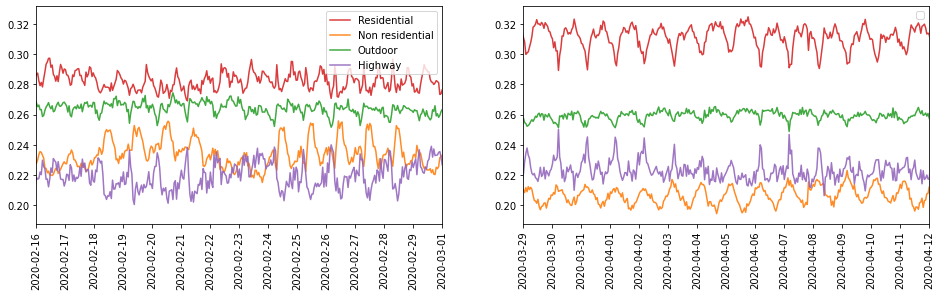

In [14]:
colors=['tab:orange', 'tab:green', 'tab:red', 'tab:purple']
timestamp_est = df_c_h_avg.index
timestamp_est = [str(x)[:10] for x in timestamp_est]

# Basic stacked area chart.
# timestamp_est = df_c_h_avg.index
x = range(len(timestamp_est))

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(x,df_c_h_avg['pct_R'], label='Residential',color=colors[2], alpha=0.9)
plt.plot(x,df_c_h_avg['pct_NR'], label='Non residential',color=colors[0], alpha=0.9)
plt.plot(x,df_c_h_avg['pct_O'], label='Outdoor',color=colors[1], alpha=0.9)
plt.plot(x,df_c_h_avg['pct_V'], label='Highway',color=colors[3], alpha=0.9)
plt.legend(loc='upper right')
plt.xticks(x[::24], timestamp_est[::24], rotation=90)
# plt.ylim(0,7)
plt.xlim(72,72+336)
plt.legend()


plt.subplot(1,2,2)
plt.plot(x,df_c_h_avg['pct_NR'], label='NR',color=colors[0], alpha=0.9)
plt.plot(x,df_c_h_avg['pct_O'], label='O',color=colors[1], alpha=0.9)
plt.plot(x,df_c_h_avg['pct_R'], label='R',color=colors[2], alpha=0.9)
plt.plot(x,df_c_h_avg['pct_V'], label='V',color=colors[3], alpha=0.9)
plt.legend(loc='upper right')
plt.xticks(x[::24], timestamp_est[::24], rotation=90)
# plt.ylim(0,7)
plt.xlim(912+168,912+336+168)
plt.legend('')
# plt.savefig('../figures/timeseries_activity_proportion_before_and_after_covid.pdf', dpi=600, bbox_inches = "tight")

plt.show()

## 2. Zipcode level aggregation
### 1) Data conversion: hourly average activities per grid cell by land use type

In [15]:
# Only take NYC and valid time period
data_nyc = data[data['label']!='NN']
data_nyc = data_nyc[(data_nyc['timestamp_est']>='2020-02-13 00:00:00')&(data_nyc['timestamp_est']<'2020-04-27 00:00:00')]

In [16]:
data_nyc.head()

,timestamp,cell_label,class,activity,timestamp_est,label,MODZCTA
1,2020-03-22 19:00:00,3;1,11.0,4,2020-03-22 15:00:00,R,10307
15,2020-03-25 09:00:00,48;51,100.0,3,2020-03-25 05:00:00,O,10301
16,2020-03-16 11:00:00,56;62,30.0,3,2020-03-16 07:00:00,NR,10301
19,2020-04-25 18:00:00,73;61,50.0,14,2020-04-25 14:00:00,O,11209
20,2020-03-28 02:00:00,77;57,100.0,6,2020-03-27 22:00:00,O,11209


In [17]:
df_z_h_avg = data_nyc.groupby(['timestamp_est', 'MODZCTA']).mean().reset_index().pivot(index='timestamp_est', 
                                                                                          columns='MODZCTA',
                                                                                      values='activity')
df_z_h_avg = df_z_h_avg.fillna(0)
df_z_h_avg.head()

MODZCTA,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11691,11692,11693,11694,11697,99999
timestamp_est,,,,,,,,,,,,,,,,,,,,,
2020-02-13 00:00:00,5.315789,4.476415,4.716578,4.150000,4.625000,3.487179,8.105263,3.861635,6.027027,4.563636,...,2.394928,3.033762,3.139881,2.745455,2.311475,2.302083,1.596491,1.646465,1.586207,3.274112
2020-02-13 01:00:00,3.673469,3.643564,3.725000,2.933333,3.666667,3.400000,4.944444,3.513889,3.785714,3.391892,...,2.150794,2.298770,2.666667,2.148148,2.165385,2.125000,1.428571,1.533333,1.166667,2.548193
2020-02-13 02:00:00,3.161111,3.005464,3.019355,2.571429,2.818182,2.551724,3.733333,2.541667,3.482353,2.795455,...,2.035573,2.080935,2.477509,1.989691,2.018349,2.024390,1.490196,1.631579,1.142857,2.170732
2020-02-13 03:00:00,3.122905,2.565476,2.605634,2.166667,2.260870,2.740741,3.512821,2.347107,3.142857,2.784000,...,2.129032,2.489564,2.332143,2.059406,1.829787,2.012821,1.584906,1.461538,1.111111,2.312057
2020-02-13 04:00:00,3.355556,2.477528,2.803030,2.058824,3.095238,3.025000,4.945946,2.306452,2.876404,2.504065,...,2.014981,2.848754,2.596721,2.596154,1.991803,2.278481,1.438596,1.479452,1.222222,2.280255


In [18]:
df_z_h_avg_label = data_nyc.groupby(['timestamp_est', 'MODZCTA', 'label']).mean().reset_index()
df_z_h_avg_label.head()

,timestamp_est,MODZCTA,label,class,activity
0,2020-02-13,10001,NR,37.405063,6.000000
1,2020-02-13,10001,O,54.380952,4.904762
2,2020-02-13,10001,R,15.074627,4.895522
3,2020-02-13,10002,NR,39.685185,3.055556
4,2020-02-13,10002,O,52.714286,4.883117


In [19]:
df_O = pd.DataFrame(index=df_z_h_avg.index, columns=df_z_h_avg.columns.tolist())
df_O.update(df_z_h_avg_label[df_z_h_avg_label['label']=='O'].pivot(index='timestamp_est', columns='MODZCTA', values='activity'))

df_R = pd.DataFrame(index=df_z_h_avg.index, columns=df_z_h_avg.columns.tolist())
df_R.update(df_z_h_avg_label[df_z_h_avg_label['label']=='R'].pivot(index='timestamp_est', columns='MODZCTA', values='activity'))

df_NR = pd.DataFrame(index=df_z_h_avg.index, columns=df_z_h_avg.columns.tolist())
df_NR.update(df_z_h_avg_label[df_z_h_avg_label['label']=='NR'].pivot(index='timestamp_est', columns='MODZCTA', values='activity'))

In [20]:
df_O = df_O.fillna(0)
df_R = df_R.fillna(0)
df_NR = df_NR.fillna(0)
df_O.head()

,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11691,11692,11693,11694,11697,99999
timestamp_est,,,,,,,,,,,,,,,,,,,,,
2020-02-13 00:00:00,4.904762,4.883117,5.314815,5.400000,3.571429,3.846154,9.466667,4.145161,5.081081,3.982456,...,1.901961,2.067485,2.840336,2.595745,2.104167,2.295455,1.458333,1.666667,2.076923,3.953488
2020-02-13 01:00:00,3.566667,3.920000,3.849057,3.625000,3.000000,3.769231,5.230769,3.703704,3.612903,2.927273,...,1.639175,1.714286,2.333333,1.886364,2.036036,2.046512,1.400000,1.457143,1.000000,2.871560
2020-02-13 02:00:00,2.931034,3.115942,3.311111,3.142857,2.500000,2.250000,2.900000,2.478261,2.892857,2.333333,...,1.620690,1.655629,2.115385,1.781250,2.021277,1.894737,1.550000,1.392857,1.000000,2.348214
2020-02-13 03:00:00,2.745455,2.553846,2.826087,3.250000,2.000000,2.777778,3.000000,2.212766,3.034483,2.697674,...,1.759036,1.760870,2.181818,1.825000,1.777778,1.883721,1.375000,1.333333,1.000000,2.715789
2020-02-13 04:00:00,3.196429,2.416667,2.729730,2.666667,2.857143,3.384615,4.333333,2.500000,2.866667,2.418605,...,1.728155,1.825503,2.351351,2.615385,1.825688,2.243243,1.185185,1.343750,1.000000,2.596154


In [21]:
# Export dataframes as csv files
# df_O.to_csv('../output/df_o_0213_0426.csv')
# df_NR.to_csv('../output/df_nr_0213_0426.csv')
# df_R.to_csv('../output/df_r_0213_0426.csv')

In [22]:
# neighborhood activity proportions by land use type
df_O_pct = df_O/(df_O+df_R+df_NR)
df_R_pct = df_R/(df_O+df_R+df_NR)
df_NR_pct = df_NR/(df_O+df_R+df_NR)

df_O_pct = df_O_pct.fillna(0)
df_R_pct = df_R_pct.fillna(0)
df_NR_pct = df_NR_pct.fillna(0)

In [23]:
# Export dataframes as csv files
# df_O_pct.to_csv('../output/df_o_pct_0213_0426.csv')
# df_NR_pct.to_csv('../output/df_nr_pct_0213_0426.csv')
# df_R_pct.to_csv('../output/df_r_pct_0213_0426.csv')

## 3. Zipcode level analysis
### Pre-covid vs. post-covid analysis

In [24]:
df_O_pre = df_O.iloc[72:72+336,:].T
df_R_pre = df_R.iloc[72:72+336,:].T
df_NR_pre = df_NR.iloc[72:72+336,:].T

df_O_pct_pre = df_O_pct.iloc[72:72+336,:].T
df_R_pct_pre = df_R_pct.iloc[72:72+336,:].T
df_NR_pct_pre = df_NR_pct.iloc[72:72+336,:].T

df_O_post = df_O.iloc[1080:1080+336,:].T 
df_R_post = df_R.iloc[1080:1080+336,:].T
df_NR_post = df_NR.iloc[1080:1080+336,:].T

df_O_pct_post = df_O_pct.iloc[1080:1080+336,:].T
df_R_pct_post = df_R_pct.iloc[1080:1080+336,:].T
df_NR_pct_post = df_NR_pct.iloc[1080:1080+336,:].T

In [25]:
df_O_pre['avg_O_pre'] = df_O_pre.mean(axis=1)
df_R_pre['avg_R_pre'] = df_R_pre.mean(axis=1)
df_NR_pre['avg_NR_pre'] = df_NR_pre.mean(axis=1)

df_O_post['avg_O_post'] = df_O_post.mean(axis=1)
df_R_post['avg_R_post'] = df_R_post.mean(axis=1)
df_NR_post['avg_NR_post'] = df_NR_post.mean(axis=1)

df_O_pct_pre['avg_O_pct_pre'] = df_O_pct_pre.mean(axis=1)
df_R_pct_pre['avg_R_pct_pre'] = df_R_pct_pre.mean(axis=1)
df_NR_pct_pre['avg_NR_pct_pre'] = df_NR_pct_pre.mean(axis=1)

df_O_pct_post['avg_O_pct_post'] = df_O_pct_post.mean(axis=1)
df_R_pct_post['avg_R_pct_post'] = df_R_pct_post.mean(axis=1)
df_NR_pct_post['avg_NR_pct_post'] = df_NR_pct_post.mean(axis=1)

df_O_pre = df_O_pre.reset_index()
df_R_pre = df_R_pre.reset_index()
df_NR_pre = df_NR_pre.reset_index()

df_O_pct_pre = df_O_pct_pre.reset_index()
df_R_pct_pre = df_R_pct_pre.reset_index()
df_NR_pct_pre = df_NR_pct_pre.reset_index()

df_O_post = df_O_post.reset_index()
df_R_post = df_R_post.reset_index()
df_NR_post = df_NR_post.reset_index()

df_O_pct_post = df_O_pct_post.reset_index()
df_R_pct_post = df_R_pct_post.reset_index()
df_NR_pct_post = df_NR_pct_post.reset_index()

In [26]:
df_cell_comp = pd.merge(df_O_pre[['index', 'avg_O_pre']],df_R_pre[['index', 'avg_R_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_pre[['index', 'avg_NR_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_O_post[['index', 'avg_O_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_R_post[['index', 'avg_R_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_post[['index', 'avg_NR_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_O_pct_pre[['index', 'avg_O_pct_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_R_pct_pre[['index', 'avg_R_pct_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_pct_pre[['index', 'avg_NR_pct_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_O_pct_post[['index', 'avg_O_pct_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_R_pct_post[['index', 'avg_R_pct_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_pct_post[['index', 'avg_NR_pct_post']], how='outer', on='index')

In [27]:
df_cell_comp['delta_O'] = df_cell_comp['avg_O_post'] - df_cell_comp['avg_O_pre']
df_cell_comp['delta_R'] = df_cell_comp['avg_R_post'] - df_cell_comp['avg_R_pre']
df_cell_comp['delta_NR'] = df_cell_comp['avg_NR_post'] - df_cell_comp['avg_NR_pre']

df_cell_comp['delta_O_norm'] = df_cell_comp['delta_O']/df_cell_comp['avg_O_pre']
df_cell_comp['delta_R_norm'] = df_cell_comp['delta_R']/df_cell_comp['avg_R_pre']
df_cell_comp['delta_NR_norm'] = df_cell_comp['delta_NR']/df_cell_comp['avg_NR_pre']

df_cell_comp['delta_O_pct'] = df_cell_comp['avg_O_pct_post'] - df_cell_comp['avg_O_pct_pre']
df_cell_comp['delta_R_pct'] = df_cell_comp['avg_R_pct_post'] - df_cell_comp['avg_R_pct_pre']
df_cell_comp['delta_NR_pct'] = df_cell_comp['avg_NR_pct_post'] - df_cell_comp['avg_NR_pct_pre']

df_cell_comp['delta_O_pct_norm'] = df_cell_comp['delta_O_pct']/df_cell_comp['avg_O_pct_pre']
df_cell_comp['delta_R_pct_norm'] = df_cell_comp['delta_R_pct']/df_cell_comp['avg_R_pct_pre']
df_cell_comp['delta_NR_pct_norm'] = df_cell_comp['delta_NR_pct']/df_cell_comp['avg_NR_pct_pre']

In [28]:
# Integrated zipcode level neighborhood activity change summary
df_cell_comp = df_cell_comp.rename(columns={"index": "MODZCTA"})
df_cell_comp.head()

timestamp_est,MODZCTA,avg_O_pre,avg_R_pre,avg_NR_pre,avg_O_post,avg_R_post,avg_NR_post,avg_O_pct_pre,avg_R_pct_pre,avg_NR_pct_pre,...,delta_NR,delta_O_norm,delta_R_norm,delta_NR_norm,delta_O_pct,delta_R_pct,delta_NR_pct,delta_O_pct_norm,delta_R_pct_norm,delta_NR_pct_norm
0,10001,8.931038,8.001633,10.651889,3.255722,3.155085,3.548806,0.319330,0.297809,0.382862,...,-7.103083,-0.635460,-0.605695,-0.666838,0.006836,0.022279,-0.029115,0.021407,0.074811,-0.076047
1,10002,6.273738,6.817812,3.376425,3.521727,4.326347,2.269152,0.376175,0.415222,0.208603,...,-1.107273,-0.438656,-0.365435,-0.327942,-0.031565,0.012228,0.019337,-0.083910,0.029449,0.092697
2,10003,7.728096,8.259152,5.663821,3.960918,2.767269,2.411350,0.352805,0.381839,0.265356,...,-3.252471,-0.487465,-0.664945,-0.574254,0.074409,-0.078070,0.003661,0.210907,-0.204457,0.013796
3,10004,9.603429,0.000000,4.455605,3.776855,0.000000,1.600569,0.677987,0.000000,0.322013,...,-2.855036,-0.606718,NaN,-0.640774,0.017766,0.000000,-0.017766,0.026205,NaN,-0.055173
4,10005,8.358210,5.820080,12.069017,2.873151,2.430899,4.309173,0.310525,0.226775,0.462700,...,-7.759845,-0.656248,-0.582325,-0.642956,-0.011554,0.033753,-0.022199,-0.037208,0.148839,-0.047977


# Mapping: spatial pattern of neighborhood activity change

In [29]:
# Join with geometry
df_cell_comp = pd.merge(zipcode, df_cell_comp, how='left', on='MODZCTA')
df_cell_comp = df_cell_comp.drop_duplicates()
df_cell_comp.head(2)

,MODZCTA,COUNTY,geometry,avg_O_pre,avg_R_pre,avg_NR_pre,avg_O_post,avg_R_post,avg_NR_post,avg_O_pct_pre,...,delta_NR,delta_O_norm,delta_R_norm,delta_NR_norm,delta_O_pct,delta_R_pct,delta_NR_pct,delta_O_pct_norm,delta_R_pct_norm,delta_NR_pct_norm
0,11420,Queens,"POLYGON ((1039302.000 182254.000, 1039280.000 ...",3.334360,3.689760,2.999669,2.841222,4.024517,2.421509,0.332827,...,-0.578160,-0.147896,0.090726,-0.192741,-0.027146,0.064802,-0.037656,-0.081562,0.175166,-0.126692
1,11434,Queens,"POLYGON ((1052176.000 175252.000, 1052346.000 ...",2.744146,3.937784,4.634949,2.581795,3.944664,2.732062,0.243567,...,-1.902887,-0.059163,0.001747,-0.410552,0.036437,0.078028,-0.114465,0.149599,0.224490,-0.279966


In [30]:
# Export zipcode level activity change summary table (comparison before covid and after the COVID)
# df_cell_comp[['MODZCTA', 'COUNTY', 'avg_O_pre', 'avg_R_pre', 'avg_NR_pre', 'avg_O_post', 'avg_R_post', 'avg_NR_post', 'avg_O_pct_pre', 'avg_R_pct_pre', 'avg_NR_pct_pre', 'avg_O_pct_post', 'avg_R_pct_post', 'avg_NR_pct_post', 'delta_O', 'delta_R', 'delta_NR', 'delta_O_norm', 'delta_R_norm', 'delta_NR_norm', 'delta_O_pct', 'delta_R_pct', 'delta_NR_pct', 'delta_O_pct_norm', 'delta_R_pct_norm', 'delta_NR_pct_norm']].to_csv('../output/activity_change_before_after_covid_zip.csv', index=False)

## 1. Measuring exposure density as infection risk
* Activities in non residential or outdoor land uses

In [31]:
df_cell_comp['avg_NRO_pre'] = df_cell_comp['avg_NR_pre'] + df_cell_comp['avg_O_pre']
df_cell_comp['avg_NRO_post'] = df_cell_comp['avg_NR_post'] + df_cell_comp['avg_O_post'] 

# Exposure density change (absolute value)
df_cell_comp['avg_NRO_delta'] = df_cell_comp['avg_NRO_post'] - df_cell_comp['avg_NRO_pre']

# Exposure density change (%)
df_cell_comp['avg_NRO_delta_pct'] = (df_cell_comp['avg_NRO_post'] - df_cell_comp['avg_NRO_pre'])/df_cell_comp['avg_NRO_pre']

In [32]:
# Drop activities in invalid zipcodes
df_cell_comp = df_cell_comp[df_cell_comp['MODZCTA']!='99999']

## 2. Mapping
* Percentage change in neighborhood activity by zipcode

In [33]:
# Load borough information
boro = gpd.read_file('../data/shape/boro.shp')
boro = boro.to_crs('EPSG:2263')
boro = boro.set_index('boro_name')

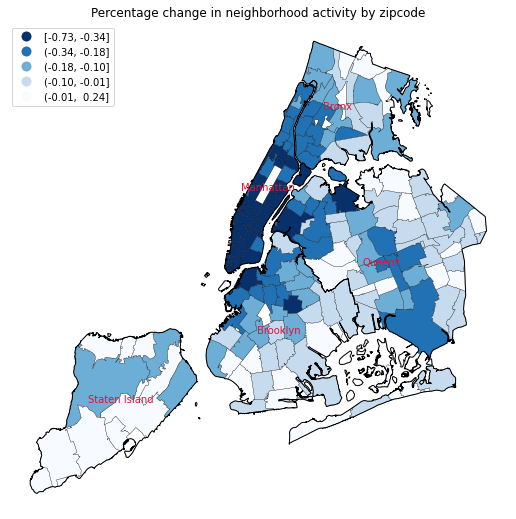

In [34]:
c = 'avg_NRO_delta_pct' # percentage change in neighborhood activity
fig, ax = plt.subplots(figsize=(9,9))
zipcode.boundary.plot(linewidth=0.2, color='k', ax=ax)

df_cell_comp[df_cell_comp[c].notnull()].plot(scheme="user_defined", 
                                             classification_kwds={'bins':[-0.34, -0.18, -0.10, -0.01]},
         legend=True,column=c, ax=ax,  cmap='Blues_r', legend_kwds={'loc': 'upper left'})

boro.boundary.plot(ax=ax, color='k', linewidth=1)

for i, geo in boro.centroid.iteritems():
    ax.annotate(s=i, xy=[geo.x-9000, geo.y], color="crimson")
    ax.figure
plt.axis('equal')
plt.axis(False)
plt.title('Percentage change in neighborhood activity by zipcode')

# plt.savefig('../figures/exposure_density_map_1m_PNAS.pdf', dpi=600)
plt.show()